# Import

In [ ]:
from tensorboardX import SummaryWriter

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 1.8 MB/s eta 0:00:00


In [ ]:
import os
import sys
import time
import re
import numpy as np
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
import math
import zipfile
import sklearn
import shutil
from glob import glob
from PIL import Image
plt.switch_backend('agg')
%matplotlib inline
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils import data
from torchvision import datasets, models, transforms
import torchvision.utils as vutils
import torch.nn.functional as F

# Test MemDPC model

In [ ]:
%cd /content/Deep-Spatial-Memory/
import sys
import json
sys.path.append('./helpers')
sys.path.append('./backbone')
args=json.load(open('./config/demo_config.json'))
from helpers.augmentation import BrightnessJitter,RandomHorizontalFlip,Scale,RandomCropWithProb,RandomSpeedTuning
from helpers.dataset import BldgDataset
from helpers.utils import (
    AverageMeter,
    save_checkpoint,
    Logger,
    neq_load_customized,
    MultiStepLR_Restart_Multiplier,
    calc_topk_accuracy,
)
from backbone.select_backbone import select_resnet
from backbone.memdpc import MemDPC_BD
from helpers.training_utils import get_data,set_path,train_one_epoch,validate


/content/Deep-Spatial-Memory


In [ ]:
def change_args(args,mem_size=128,epochs = 60,batch_size=8,p= 0.65,lr=5e-4,wd=1e-4,drop_out=0.3,data_path = './casestudy_1228_test.zip',net = 'resnet18'): # try batch size
  args['mem_size'] = mem_size
  args['epochs'] = epochs
  # args['workers'] = 12
  args['batch_size'] = batch_size
  args['p'] =p
  args['lr']=lr
  args['wd']=wd
  args['data_path'] = data_path
  args['workers'] = 2
  args['drop_out'] = drop_out
  args['net'] = net
  return args
args = change_args(args)

In [ ]:
import os
import gdown
import zipfile
data_link = 'https://drive.google.com/file/d/1t7oC94qUNYAb_unkCbv4aXYyaU3wl4ha/view?usp=sharing'
gdown.download(data_link,fuzzy=True)


Downloading...
From: https://drive.google.com/uc?id=1t7oC94qUNYAb_unkCbv4aXYyaU3wl4ha
To: /content/Deep-Spatial-Memory/casestudy_1228_test.zip
100%|██████████| 51.7M/51.7M [00:01<00:00, 34.0MB/s]


'casestudy_1228_test.zip'

In [ ]:
import os
import gdown
import zipfile
data_link_demo = 'https://drive.google.com/file/d/1jF6AE5orR9ycs43awWylAq690Usdn3RL/view?usp=drive_link'
data_link_combined = 'https://drive.google.com/file/d/1HS1PRi_YRvKgoIgOiz2cwIb5bDyMNxEN/view?usp=sharing'
gdown.download(data_link_demo,fuzzy=True)
gdown.download(data_link_combined,fuzzy=True)

Downloading...
From: https://drive.google.com/uc?id=1jF6AE5orR9ycs43awWylAq690Usdn3RL
To: /content/Deep-Spatial-Memory/demo_1120.zip
100%|██████████| 91.0M/91.0M [00:01<00:00, 60.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1HS1PRi_YRvKgoIgOiz2cwIb5bDyMNxEN
To: /content/Deep-Spatial-Memory/casestudy_1126_combine_vis.zip
100%|██████████| 146M/146M [00:02<00:00, 67.8MB/s]


'casestudy_1126_combine_vis.zip'

## Load model

In [ ]:
import os
import gdown
import zipfile

# Google Drive shareable link
memdpc_link = 'https://drive.google.com/file/d/1FO-_UtUw7AOzDy5X4nzuw9kATkk8ctM0/view?usp=sharing'

# Download destination
download_path = './temp_download.zip'

# Download the file from Google Drive
gdown.download(memdpc_link,fuzzy=True,output=download_path)

# Directory to extract to
extract_to = './log_tmp_original'

# Create the directory if it doesn't exist
if not os.path.exists(extract_to):
    os.makedirs(extract_to)

# Extract the contents of the zip file
with zipfile.ZipFile(download_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

# Optionally, remove the zip file after extraction
os.remove(download_path)

print(f'Contents extracted to {extract_to}')

Downloading...
From: https://drive.google.com/uc?id=1FO-_UtUw7AOzDy5X4nzuw9kATkk8ctM0
To: /content/Deep-Spatial-Memory/temp_download.zip
100%|██████████| 304M/304M [00:05<00:00, 55.2MB/s]


Contents extracted to ./log_tmp_original


In [ ]:
from helpers.utils import neq_load_customized
memdpc = MemDPC_BD(sample_size=args['img_dim'],
                          num_seq=args['num_seq'],
                          seq_len=args['seq_len'],
                          network=args['net'],
                          pred_step=args['pred_step'],
                          mem_size=args['mem_size'])
exp_path = f"log_{args['prefix']}_original"
model_dir = os.listdir(exp_path)[0]
model_dir = os.path.join(exp_path, model_dir,'model')
model_file = ''
for file in os.listdir(model_dir):
  if 'best' in file:
    model_file = file

model_path = os.path.join(model_dir, model_file)
checkpoint = torch.load(model_path)
memdpc = neq_load_customized(memdpc, checkpoint['state_dict'])

Using MemDPC-BiDirectional model with resnet18 and mem_size 128
final feature map has size 1x2
MEM Bank has size 128x256

=======Check Weights Loading======
Weights not used from pretrained file:
---------------------------
Weights not loaded into new model:



In [ ]:
from torchvision import transforms
from torch.utils.data import DataLoader
dataset = BldgDataset(data_path = args["data_path"],mode='predict',  seq_len=args['seq_len'], num_seq=args['num_seq'])

Loading pantheon: 100%|██████████| 100/100 [00:00<00:00, 204.27path/s]


In [ ]:
dataset_demo = BldgDataset(data_path = './demo_1120.zip',mode='predict',  seq_len=args['seq_len'], num_seq=args['num_seq'])

Loading demo: 100%|██████████| 300/300 [00:01<00:00, 218.52path/s]


In [ ]:
dataset_combined = BldgDataset(data_path = './casestudy_1126_combine_vis.zip',mode='predict',  seq_len=args['seq_len'], num_seq=args['num_seq'])

Loading demo: 100%|██████████| 300/300 [00:04<00:00, 64.33path/s]


## tSNE

In [ ]:
device = torch.device('cuda')
memdpc.to(device)
memdpc.eval()
updated_dataset=[]
context_features = []
context_features_ori = []
labels = []
path_numbers = []
for data in dataset:
    with torch.no_grad():  # No need to compute gradients during inference
        # Unpack the batch
        updated_data ={}
        t_seq, path_number = data["t_imgs"],data["path"]
        label = data["bldg"] +'_' +data["start_type"] + '_'+ data["end_type"]+'_'+data['route']
        t_seq = t_seq.to(device)
        # Get the context features from the model
        context_feature = memdpc.extract_features(t_seq.unsqueeze(0))
        context_features_ori.append(context_feature.cpu())
        # Perform global average pooling
        pooling_layer = torch.nn.AdaptiveAvgPool2d((1,1))
        pooled_context_feature = pooling_layer(context_feature)
        # Store the context features, labels, and path numbers
        context_features.append(pooled_context_feature.cpu())
        updated_data["feature"] = pooled_context_feature.cpu().reshape(-1,1).numpy().tolist()
        updated_data["bldg"] = data["bldg"]
        updated_data["route"] = data["route"]
        updated_data["path"] = data["path"]
        updated_data["start_type"] =data["start_type"]
        updated_data["end_type"] =data["end_type"]
        updated_dataset.append(updated_data)
        labels.append(label)
        path_numbers.append(path_number)

# Concatenate all context features, labels, and path numbers into individual tensors
context_features_ori = torch.cat(context_features_ori,dim=0)
context_features = torch.cat(context_features, dim=0)
# path_numbers = torch.cat(path_numbers, dim=0)

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Step 1: Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Step 2: Fit the LabelEncoder on the list of tuples by converting the tuple to a string
# We convert tuple to string because LabelEncoder expects 1D array or list
label_encoder.fit(labels)

# Step 3: Transform the list of tuples using the fitted LabelEncoder
# Map each tuple to a number by converting the tuple to a string first
numerical_labels = label_encoder.transform(labels)

# Step 4: Create a dictionary mapping tuples to their numerical labels (optional)
# This maps the string representation back to the original tuple
idx_to_label = {index: label for index, label in enumerate(label_encoder.classes_)}
label_to_idx = {label: index for index, label in idx_to_label.items()}

# Print the results
# print("Numerical Labels:", numerical_labels)
print("idx to Label Map:", idx_to_label)
print("Label to idx Map:", label_to_idx)
context_features = context_features.reshape(context_features.shape[0], -1)

idx to Label Map: {0: 'caracalla_exterior_exterior_exercisespace', 1: 'caracalla_passage_exterior_circling', 2: 'caracalla_passage_room_passage2steambath', 3: 'iim_exterior_exterior_plaza', 4: 'iim_passage_room_classroom', 5: 'iim_room_exterior_entrance2terrace', 6: 'pantheon_exterior_exterior_plaza', 7: 'pantheon_room_room_column2interiorb', 8: 'pantheon_room_room_columnsb', 9: 'trajan_exterior_exterior_plaza', 10: 'trajan_passage_passage_mainhallgf', 11: 'trajan_room_exterior_terrace'}
Label to idx Map: {'caracalla_exterior_exterior_exercisespace': 0, 'caracalla_passage_exterior_circling': 1, 'caracalla_passage_room_passage2steambath': 2, 'iim_exterior_exterior_plaza': 3, 'iim_passage_room_classroom': 4, 'iim_room_exterior_entrance2terrace': 5, 'pantheon_exterior_exterior_plaza': 6, 'pantheon_room_room_column2interiorb': 7, 'pantheon_room_room_columnsb': 8, 'trajan_exterior_exterior_plaza': 9, 'trajan_passage_passage_mainhallgf': 10, 'trajan_room_exterior_terrace': 11}


In [ ]:
import numpy as np
import plotly.express as px
import pandas as pd
from sklearn.manifold import TSNE
import plotly.graph_objects as go
# Perform t-SNE for dimensionality reduction


np.random.seed(125)
tsne = TSNE(n_components=2, random_state=125, perplexity=70,n_iter=1000)
reduced_features = tsne.fit_transform(context_features)

In [ ]:
# Create data frame from X_tsne and Y_frame
color_palette = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
                 '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

color_map = {label: color_palette[idx % len(color_palette)] for idx, label in idx_to_label.items()}

data_pred = np.concatenate((reduced_features, numerical_labels.reshape(-1,1)), axis=1)

# Create a DataFrame with reduced features
df = pd.DataFrame(data_pred, columns=['x', 'y', 'label'])
# Map numerical labels to tuple labels
df['label'] = df['label'].map(lambda x: idx_to_label[int(x)])

mean_coordinates = df.groupby('label').mean().reset_index()
# Generate a color palette with a unique color for each label
unique_labels = df['label'].unique()
colors = px.colors.qualitative.Dark24  # Using a Plotly qualitative color palette
color_discrete_map = {label: color_map[label] for _, label in enumerate(unique_labels)}

# Plot scatter plot with annotations
fig = px.scatter(df, x='x', y='y', color='label', color_discrete_map=color_discrete_map)
fig.update_traces(marker=dict(size=5,opacity=0.8),
                  selector=dict(mode='markers'))

# for idx, row in mean_coordinates.iterrows():
#     fig.add_trace(go.Scatter(x=[row['x']], y=[row['y']], text=[row['label'].split("_")[0]], mode='text', showlegend=False))
fig.update_layout(
    width=1000,
    height=800,
    title="t-SNE Visualization of Building Spatial Sequences",
    plot_bgcolor="white",  # Set plot background to white
    xaxis=dict(showgrid=False),  # Remove x-axis grid lines
    yaxis=dict(showgrid=False),  # Remove y-axis grid lines
    xaxis_showticklabels=True,  # Optional: Display x-axis tick labels
    yaxis_showticklabels=True,  # Optional: Display y-axis tick labels
)

# Show plot
fig.show()

In [ ]:
import numpy as np
import plotly.express as px
import pandas as pd
from sklearn.decomposition import PCA
import plotly.graph_objects as go
# Perform t-SNE for dimensionality reduction


np.random.seed(125)
pca = PCA(n_components=2, random_state=22)
reduced_features_pca = pca.fit_transform(context_features)

In [ ]:
# Create data frame from X_tsne and Y_frame
color_palette = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
                 '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

color_map = {label: color_palette[idx % len(color_palette)] for idx, label in idx_to_label.items()}

data_pred = np.concatenate((reduced_features_pca, numerical_labels.reshape(-1,1)), axis=1)

# Create a DataFrame with reduced features
df = pd.DataFrame(data_pred, columns=['x', 'y', 'label'])
# Map numerical labels to tuple labels
df['label'] = df['label'].map(lambda x: idx_to_label[int(x)])

mean_coordinates = df.groupby('label').mean().reset_index()
# Generate a color palette with a unique color for each label
unique_labels = df['label'].unique()
colors = px.colors.qualitative.Dark24  # Using a Plotly qualitative color palette
color_discrete_map = {label: color_map[label] for _, label in enumerate(unique_labels)}

# Plot scatter plot with annotations
fig = px.scatter(df, x='x', y='y', color='label', color_discrete_map=color_discrete_map)
fig.update_traces(marker=dict(size=5,opacity=0.8),
                  selector=dict(mode='markers'))

# for idx, row in mean_coordinates.iterrows():
#     fig.add_trace(go.Scatter(x=[row['x']], y=[row['y']], text=[row['label'].split("_")[0]], mode='text', showlegend=False))
fig.update_layout(
    width=1000,
    height=800,
    title="pca Visualization of Building Spatial Sequences",
    plot_bgcolor="white",  # Set plot background to white
    xaxis=dict(showgrid=False),  # Remove x-axis grid lines
    yaxis=dict(showgrid=False),  # Remove y-axis grid lines
    xaxis_showticklabels=True,  # Optional: Display x-axis tick labels
    yaxis_showticklabels=True,  # Optional: Display y-axis tick labels
)

# Show plot
fig.show()

# test Finetuned MLP

In [ ]:
import os
import gdown
import zipfile

# Google Drive shareable link
mlp_link = 'https://drive.google.com/file/d/1QI1oAC45lX41U0jFvP_av0woggQ0EEg0/view?usp=sharing'

# Download destination
download_path = './mlp_model.pth'

# Download the file from Google Drive
gdown.download(mlp_link,fuzzy=True,output=download_path)


Downloading...
From: https://drive.google.com/uc?id=1QI1oAC45lX41U0jFvP_av0woggQ0EEg0
To: /content/Deep-Spatial-Memory/mlp_model.pth
100%|██████████| 177k/177k [00:00<00:00, 50.6MB/s]


'./mlp_model.pth'

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR

class MLPClassifier(nn.Module):
    def __init__(self):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64,32)
        self.fc4 = nn.Linear(32, 6)  # Output layer

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = torch.sigmoid(self.fc4(x))
        return x


In [ ]:
mlp_model = MLPClassifier()
# Load the state dictionary
model_path = 'mlp_model.pth'  # Replace with the path to your saved model
mlp_model.load_state_dict(torch.load(model_path))
mlp_model.eval()

MLPClassifier(
  (fc1): Linear(in_features=256, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=6, bias=True)
)

In [ ]:
def extract_single_feature(memdpc, single_data):
    """
    Extract features from a single data point using the MemDPC model.

    Args:
    - memdpc (PyTorch Model): The MemDPC model instance.
    - single_data (Tensor): A single data point, shape (C, H, W).

    Returns:
    - Tensor: Extracted features from the data point, shape (1, feature_dim).
    """
    # Ensure the model is in evaluation mode and the data is on the same device as the model
    memdpc.eval()
    device = next(memdpc.parameters()).device  # Get the device of the model
    single_data = single_data.to(device)

    # Extract features for the single data point
    with torch.no_grad():
        context_feature = memdpc.extract_features(single_data.unsqueeze(0))  # Add batch dimension
        # Perform global average pooling
        pooling_layer = torch.nn.AdaptiveAvgPool2d((1, 1))
        pooled_context_feature = pooling_layer(context_feature)
        features = pooled_context_feature.view(-1, 256)

    return features

In [ ]:
def extract_batch_features(memdpc, batch_data):
    """
    Extract features from a batch of data using the MemDPC model.

    Args:
    - memdpc (PyTorch Model): The MemDPC model instance.
    - batch_data (Tensor): A batch of data, shape (batch_size, C, H, W).

    Returns:
    - Tensor: Extracted features from the batch, shape (batch_size, feature_dim).
    """
    batch_features = []

    # Ensure the model is in evaluation mode and the batch data is on the same device as the model
    memdpc.eval()
    device = next(memdpc.parameters()).device  # Get the device of the model
    batch_data = batch_data.to(device)

    # Loop over each item in the batch
    for i in range(batch_data.shape[0]):
        # Extract features for each item
        with torch.no_grad():
            context_feature = memdpc.extract_features(batch_data[i].unsqueeze(0))  # Add batch dimension
            # Perform global average pooling
            pooling_layer = torch.nn.AdaptiveAvgPool2d((1, 1))
            pooled_context_feature = pooling_layer(context_feature)
            features = pooled_context_feature.view(-1, 256)
            batch_features.append(features)

    # Stack all features to form a batch
    features_batch = torch.cat(batch_features, dim=0)
    return features_batch
label_map = {"room":0,"passage":1,"exterior":2}

In [ ]:
from collections import defaultdict
label_map = {"room":0,"passage":1,"exterior":2}
inverse_map =  {0:"room",1:"passage",2:"exterior"}
test_loader = DataLoader(dataset=dataset, batch_size=32, shuffle=False)

# Initialize dictionaries to track correct and total predictions for each combined label
correct_predictions_by_combined_label = defaultdict(int)
total_predictions_by_combined_label = defaultdict(int)
misclassified_predictions = defaultdict(lambda: defaultdict(int))

mlp_model.to(device)
memdpc.to(device)

with torch.no_grad():
    correct_predictions = 0
    total_predictions = 0
    for batch in test_loader:
        # Extract features from test data
        t_imgs = batch['t_imgs'].to(device)
        features = extract_batch_features(memdpc, t_imgs)

        # Forward pass through MLP classifier
        outputs = mlp_model(features)
        start_probs, end_probs = outputs[:, :3], outputs[:, 3:]

        # Prepare labels
        start_labels = torch.tensor([label_map[label] for label in batch['start_type']]).to(device)
        end_labels = torch.tensor([label_map[label] for label in batch['end_type']]).to(device)

        # Predictions
        _, start_predictions = torch.max(start_probs, 1)
        _, end_predictions = torch.max(end_probs, 1)

        # Update correct and total predictions for each combined label
        for i in range(start_labels.size(0)):  # Iterate over each instance in the batch
            start_label = batch['start_type'][i]
            end_label = batch['end_type'][i]
            actual_combined_label = start_label + '+' + end_label
            predicted_combined_label = inverse_map[int(start_predictions[i])] + '+' + inverse_map[int(end_predictions[i])]
            correct = actual_combined_label == predicted_combined_label
            correct_predictions_by_combined_label[actual_combined_label] += int(correct)
            total_predictions_by_combined_label[actual_combined_label] += 1
            if actual_combined_label != predicted_combined_label:
                misclassified_predictions[actual_combined_label][predicted_combined_label] += 1

        # Increment correct and total predictions
        correct_predictions += ((start_predictions == start_labels) & (end_predictions == end_labels)).sum().item()
        total_predictions += start_labels.size(0)

# Calculate overall accuracy
accuracy = correct_predictions / total_predictions
print(f"Accuracy on test set (both start and end types correct): {accuracy * 100:.2f}%")
# Calculate and print accuracy for each combined label
for combined_label in set(total_predictions_by_combined_label.keys()):
    if total_predictions_by_combined_label[combined_label] > 0:
        accuracy = correct_predictions_by_combined_label[combined_label] / total_predictions_by_combined_label[combined_label]
        print(f"Accuracy for combined label '{combined_label}': {accuracy * 100:.2f}%")
    else:
        print(f"No predictions for combined label '{combined_label}'")

for actual_label, predicted_labels in misclassified_predictions.items():
    print(f"Actual Label: {actual_label}")
    for predicted_label, count in predicted_labels.items():
        print(f"  Misclassified as {predicted_label}: {count} times")

Accuracy on test set (both start and end types correct): 71.92%
Accuracy for combined label 'room+room': 29.50%
Accuracy for combined label 'exterior+exterior': 84.75%
Accuracy for combined label 'passage+passage': 100.00%
Accuracy for combined label 'room+exterior': 96.50%
Accuracy for combined label 'passage+exterior': 0.00%
Accuracy for combined label 'passage+room': 86.00%
Actual Label: exterior+exterior
  Misclassified as room+exterior: 61 times
Actual Label: room+room
  Misclassified as exterior+room: 37 times
  Misclassified as room+exterior: 32 times
  Misclassified as exterior+exterior: 32 times
  Misclassified as room+passage: 40 times
Actual Label: passage+room
  Misclassified as room+room: 13 times
  Misclassified as passage+exterior: 3 times
  Misclassified as room+passage: 1 times
  Misclassified as passage+passage: 10 times
  Misclassified as room+exterior: 1 times
Actual Label: passage+exterior
  Misclassified as room+exterior: 100 times
Actual Label: room+exterior
  Mi

In [ ]:
from collections import defaultdict
label_map = {"room":0,"passage":1,"exterior":2}
inverse_map =  {0:"room",1:"passage",2:"exterior"}
test_loader = DataLoader(dataset=dataset, batch_size=32, shuffle=False)

# Initialize dictionaries for tracking results by building
results_by_building_and_route = defaultdict(lambda: defaultdict(lambda: defaultdict(int)))
misclassified_by_building_and_route = defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: defaultdict(int))))

mlp_model.to(device)
memdpc.to(device)

with torch.no_grad():
    for batch in test_loader:
        # Extract features from test data
        t_imgs = batch['t_imgs'].to(device)
        features = extract_batch_features(memdpc, t_imgs)

        # Forward pass through MLP classifier
        outputs = mlp_model(features)
        start_probs, end_probs = outputs[:, :3], outputs[:, 3:]

        # Prepare labels
        start_labels = torch.tensor([label_map[label] for label in batch['start_type']]).to(device)
        end_labels = torch.tensor([label_map[label] for label in batch['end_type']]).to(device)

        # Predictions
        _, start_predictions = torch.max(start_probs, 1)
        _, end_predictions = torch.max(end_probs, 1)

        # Group results by building
        for i in range(start_labels.size(0)):
            building = batch['bldg'][i]
            route = batch['route'][i]
            actual_combined_label = batch['start_type'][i] + '+' + batch['end_type'][i]
            predicted_combined_label = inverse_map[int(start_predictions[i])] + '+' + inverse_map[int(end_predictions[i])]

            correct = actual_combined_label == predicted_combined_label
            results_by_building_and_route[building][route][actual_combined_label] += int(correct)
            results_by_building_and_route[building][route]['total'] += 1

            if not correct:
                misclassified_by_building_and_route[building][route][actual_combined_label][predicted_combined_label] += 1



In [ ]:
# Print results grouped by building and route
for building, routes in results_by_building_and_route.items():
    print(f"Results for Building: {building}")
    for route, results in routes.items():
        print(f"  Route: {route}")
        total_predictions = results['total']
        if total_predictions > 0:
            for combined_label, correct_count in results.items():
                if combined_label != 'total':
                    accuracy = correct_count / total_predictions
                    print(f"    Accuracy for '{combined_label}': {accuracy * 100:.2f}%")
        else:
            print("    No predictions for this route")

        # Print misclassified cases for this route
        if route in misclassified_by_building_and_route[building]:
            print("    Misclassified Cases:")
            for actual_label, predicted_labels in misclassified_by_building_and_route[building][route].items():
                print(f"      Actual Label: {actual_label}")
                for predicted_label, count in predicted_labels.items():
                    print(f"        Misclassified as {predicted_label}: {count} times")

Results for Building: pantheon
  Route: column2interiorb
    Accuracy for 'room+room': 45.00%
    Misclassified Cases:
      Actual Label: room+room
        Misclassified as room+exterior: 21 times
        Misclassified as room+passage: 34 times
  Route: columnsb
    Accuracy for 'room+room': 14.00%
    Misclassified Cases:
      Actual Label: room+room
        Misclassified as exterior+room: 37 times
        Misclassified as exterior+exterior: 32 times
        Misclassified as room+passage: 6 times
        Misclassified as room+exterior: 11 times
  Route: plaza
    Accuracy for 'exterior+exterior': 100.00%
Results for Building: trajan
  Route: plaza
    Accuracy for 'exterior+exterior': 60.00%
    Misclassified Cases:
      Actual Label: exterior+exterior
        Misclassified as room+exterior: 40 times
  Route: mainhallgf
    Accuracy for 'passage+passage': 100.00%
  Route: terrace
    Accuracy for 'room+exterior': 100.00%
Results for Building: caracalla
  Route: exercisespace
    Ac

In [ ]:
import pandas as pd
data_for_df = []

# Process the results for DataFrame
for building, routes in results_by_building_and_route.items():
    for route, results in routes.items():
        for actual_label, correct_count in results.items():
            if actual_label != 'total':
                total_predictions = results['total']
                accuracy = correct_count / total_predictions if total_predictions > 0 else 0

                # Prepare data for misclassified labels
                misclassifications = misclassified_by_building_and_route[building][route][actual_label]
                misclass_sorted = sorted(misclassifications.items(), key=lambda x: x[1], reverse=True)[:3]
                misclass_data = [None] * 6  # Initialize with None values
                for i, (misclass_label, misclass_count) in enumerate(misclass_sorted):
                    misclass_data[i*2] = misclass_label
                    misclass_data[i*2 + 1] = misclass_count

                # Add a row to the data list
                data_for_df.append([building, route, actual_label, inverse_map[int(start_predictions[i])]+'+'+inverse_map[int(end_predictions[i])], accuracy] + misclass_data)

# Create DataFrame
columns = ['bldg', 'route', 'actual label', 'predicted label', 'accuracy',
           'misclassified label 1', 'misclassified label 1 times',
           'misclassified label 2', 'misclassified label 2 times',
           'misclassified label 3', 'misclassified label 3 times']
df = pd.DataFrame(data_for_df, columns=columns)

# Export to Excel
df.to_excel('test_results.xlsx', index=False)

## Export Path Prediction

In [ ]:
for data in updated_dataset:
        # Extract the features and predict using the model
        features = data['feature']
        features = torch.tensor(features).reshape(1,-1)
        with torch.no_grad():

          predictions = mlp_model(features.to(device))
          predictions = predictions.detach().cpu().numpy()[0]

        # Decode the predictions for start and end types
        start_type = inverse_map[np.argmax(predictions[:3])]
        end_type = inverse_map[np.argmax(predictions[3:])]

        # Combine the predictions and update the dataset
        data['prediction'] = f'{start_type} to {end_type}'

In [ ]:
import pandas as pd

def export_to_excel(title, dataset):
    # Split the title into building and route
    bldg, route = title.split('_')

    # Filter the dataset for entries matching the building and route
    filtered_data = [data for data in dataset if data['bldg'] == bldg and data['route'] == route]

    # Convert the filtered data to a DataFrame
    df = pd.DataFrame({
        'path': [data['path'] for data in filtered_data],
        'prediction': [data['prediction'] for data in filtered_data]
    })

    # Export to Excel
    filename = title + '.csv'
    df.to_csv(filename, index=False)
    print(f'Data exported to {filename}')

In [ ]:
export_to_excel('pantheon_columnsb', updated_dataset)

Data exported to pantheon_columnsb.csv


# Plot Feature Analysis

## updated dataset

In [ ]:
prediction_dataset = []
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
label_map = {"room":0,"passage":1,"exterior":2}
inverse_map =  {0:"room",1:"passage",2:"exterior"}
mlp_model.to(device)
memdpc.to(device)
for i,data in enumerate(dataset):
  updated_data = {}
  t_img = data['t_imgs'].to(device)
  feature = extract_single_feature(memdpc, t_img)
  updated_data['feature'] = feature
  updated_data['bldg'] = data['bldg']
  updated_data['route'] = data['route']
  updated_data['start_type'] = data['start_type']
  updated_data['end_type'] = data['end_type']
  outputs = mlp_model(feature.unsqueeze(0)).squeeze(0)
  start_probs, end_probs = outputs[:, :3], outputs[:, 3:]
  start_probs = start_probs.detach().cpu().numpy()[0]
  end_probs = end_probs.detach().cpu().numpy()[0]
  updated_data['start_prediction'] = start_probs
  updated_data['end_prediction'] = end_probs
  prediction_dataset.append(updated_data)

print(len(prediction_dataset))



NameError: ignored

In [ ]:
from collections import defaultdict
import numpy as np

# Aggregate predictions
aggregated_data = defaultdict(lambda: {'start': np.zeros(3), 'end': np.zeros(3), 'count': 0})

for item in prediction_dataset:
    key = item['bldg'] + '+' + item['route']
    aggregated_data[key]['start'] += np.array(item['start_prediction'])
    aggregated_data[key]['end'] += np.array(item['end_prediction'])
    aggregated_data[key]['count'] += 1

# Average the predictions
for key in aggregated_data:
    aggregated_data[key]['start'] /= aggregated_data[key]['count']
    aggregated_data[key]['end'] /= aggregated_data[key]['count']

# Determine the predicted start and end types
predicted_labels = {}
for key, value in aggregated_data.items():
    start_type = np.argmax(value['start'])
    end_type = np.argmax(value['end'])
    predicted_labels[key] = (start_type, end_type)

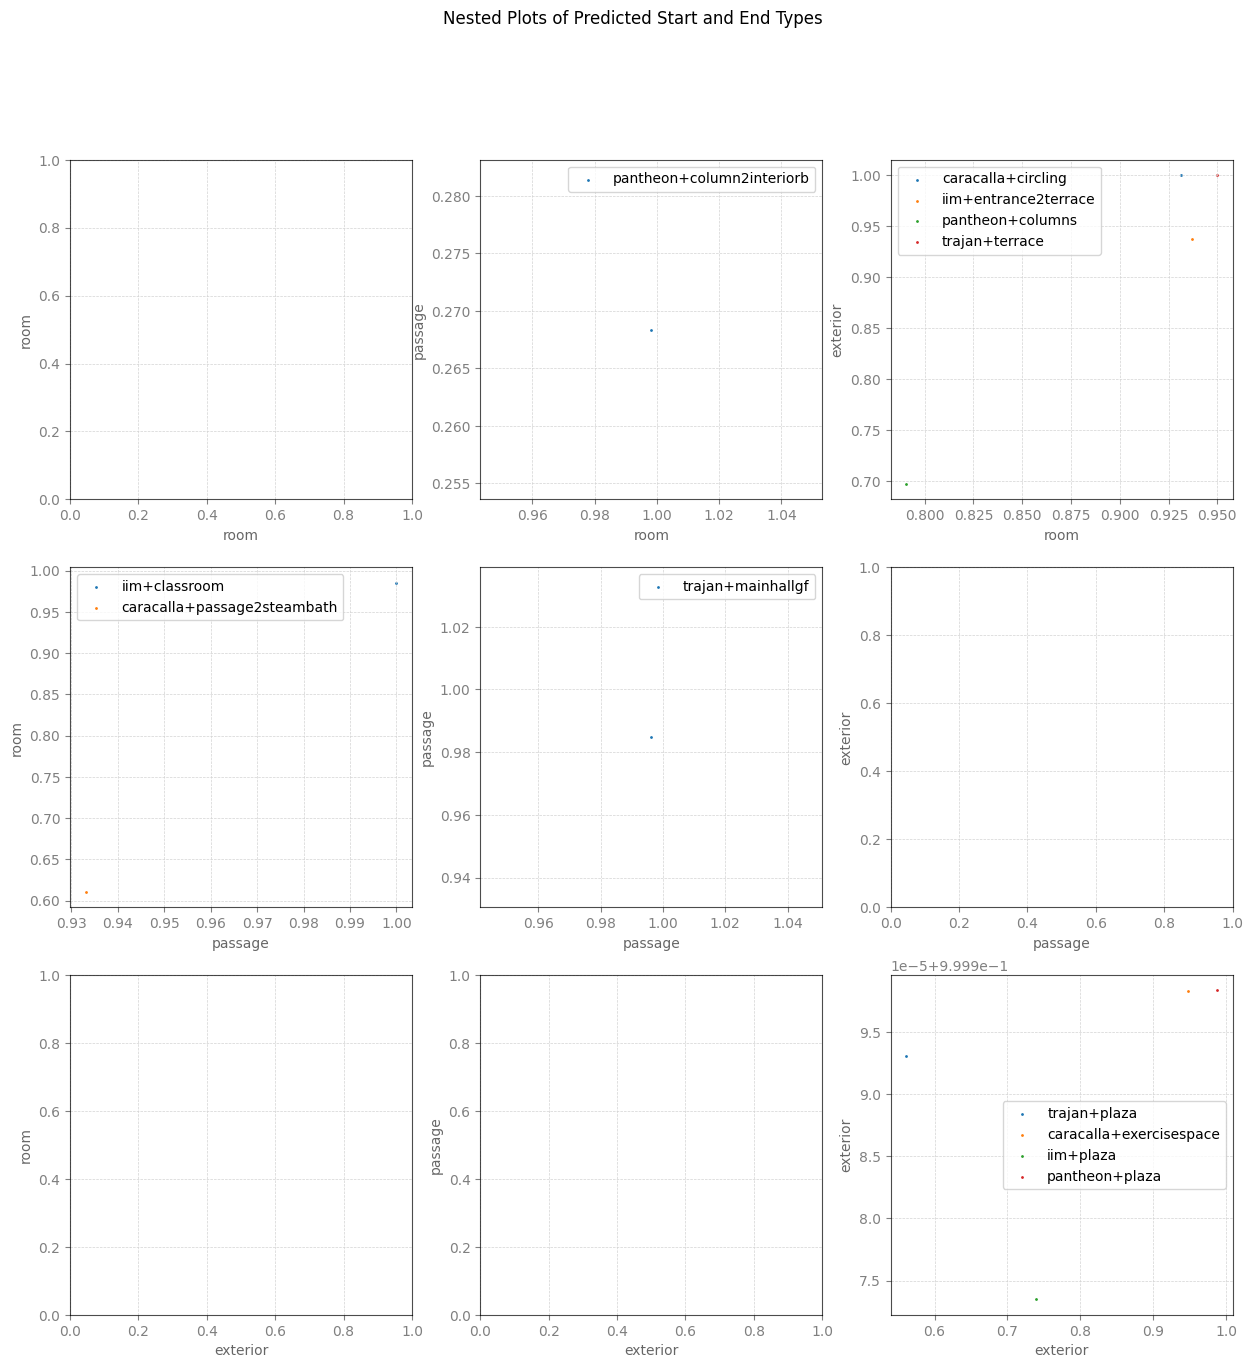

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

# Create a 3x3 grid of plots
fig, axs = plt.subplots(3, 3, figsize=(15, 15))
fig.suptitle('Nested Plots of Predicted Start and End Types')

# Plot each point in the appropriate subplot
for i in range(3):
    for j in range(3):
        # Set the inner grid with a lighter grey color and thin dashed lines
        axs[i, j].grid(True, which='both', linestyle='--', linewidth=0.5, color='lightgrey')

        # Set the labels with a standard grey color
        axs[i, j].set_xlabel(inverse_map[i], color=(0, 0, 0, 0.6))
        axs[i, j].set_ylabel(inverse_map[j], color=(0, 0, 0, 0.6))

        # Set the spines to a darker grey color
        for spine in axs[i, j].spines.values():
            spine.set_edgecolor((0, 0, 0, 0.7))

        # Set the tick labels to standard grey color
        axs[i, j].tick_params(colors='grey', which='both')

for key, (start_type, end_type) in predicted_labels.items():
    start_prob = aggregated_data[key]['start'][start_type]
    end_prob = aggregated_data[key]['end'][end_type]
    axs[start_type, end_type].scatter(start_prob, end_prob, label=key,s=1)
    axs[start_type, end_type].legend()

plt.show()

In [ ]:
print(aggregated_data['caracalla+passage2steambath'])

{'start': array([3.79083412e-01, 9.33032835e-01, 4.46799004e-08]), 'end': array([0.61086776, 0.09363204, 0.08083944]), 'count': 100}


In [ ]:
print(grouped_data['caracallapassage2steambath']['xy_values'])

[(0.86200196, 0.726634), (0.994612, 0.57836485), (0.87163115, 0.6048392), (0.85816574, 0.52272797), (0.99982685, 0.80657965), (0.9308922, 0.5882367), (0.98685396, 0.5845015), (0.94756806, 0.5353481), (0.96523815, 0.85132575), (0.99973744, 0.81971174), (0.99068063, 0.55826205), (0.91978836, 0.59989786), (0.9814114, 0.37024125), (0.99928814, 0.8144723), (0.97682345, 0.4552811), (0.99923027, 0.72428876), (0.9920488, 0.5184541), (0.9066816, 0.9503245), (0.9336569, 0.7250834), (0.9820087, 0.32311803), (0.9148922, 0.39981803), (0.957056, 0.72613907), (0.9842163, 0.7717767), (0.99786276, 0.40272078), (0.9286465, 0.6316341), (0.99795294, 0.9108778), (0.98462266, 0.98653644), (0.9882168, 0.58939403), (0.8508823, 0.5370513), (0.9960515, 0.52974933), (0.89421093, 0.34984824), (0.9121322, 0.45726258), (0.9892904, 0.569797), (0.9526293, 0.4794442), (0.98697543, 0.8973238), (0.9435657, 0.5564839), (0.98807204, 0.39073306), (0.9654723, 0.40204638), (0.9979024, 0.8019212), (0.99528414, 0.4828636), (0.

In [ ]:
print(grouped_data.keys())

dict_keys(['pantheon+column2interiorb', 'trajan+plaza', 'caracalla+circling', 'iim+classroom', 'caracalla+exercisespace', 'iim+plaza', 'trajan+mainhallgf', 'caracalla+passage2steambath', 'iim+entrance2terrace', 'pantheon+columns', 'pantheon+plaza', 'trajan+terrace'])


<ipython-input-55-64cf254f2575>:9: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



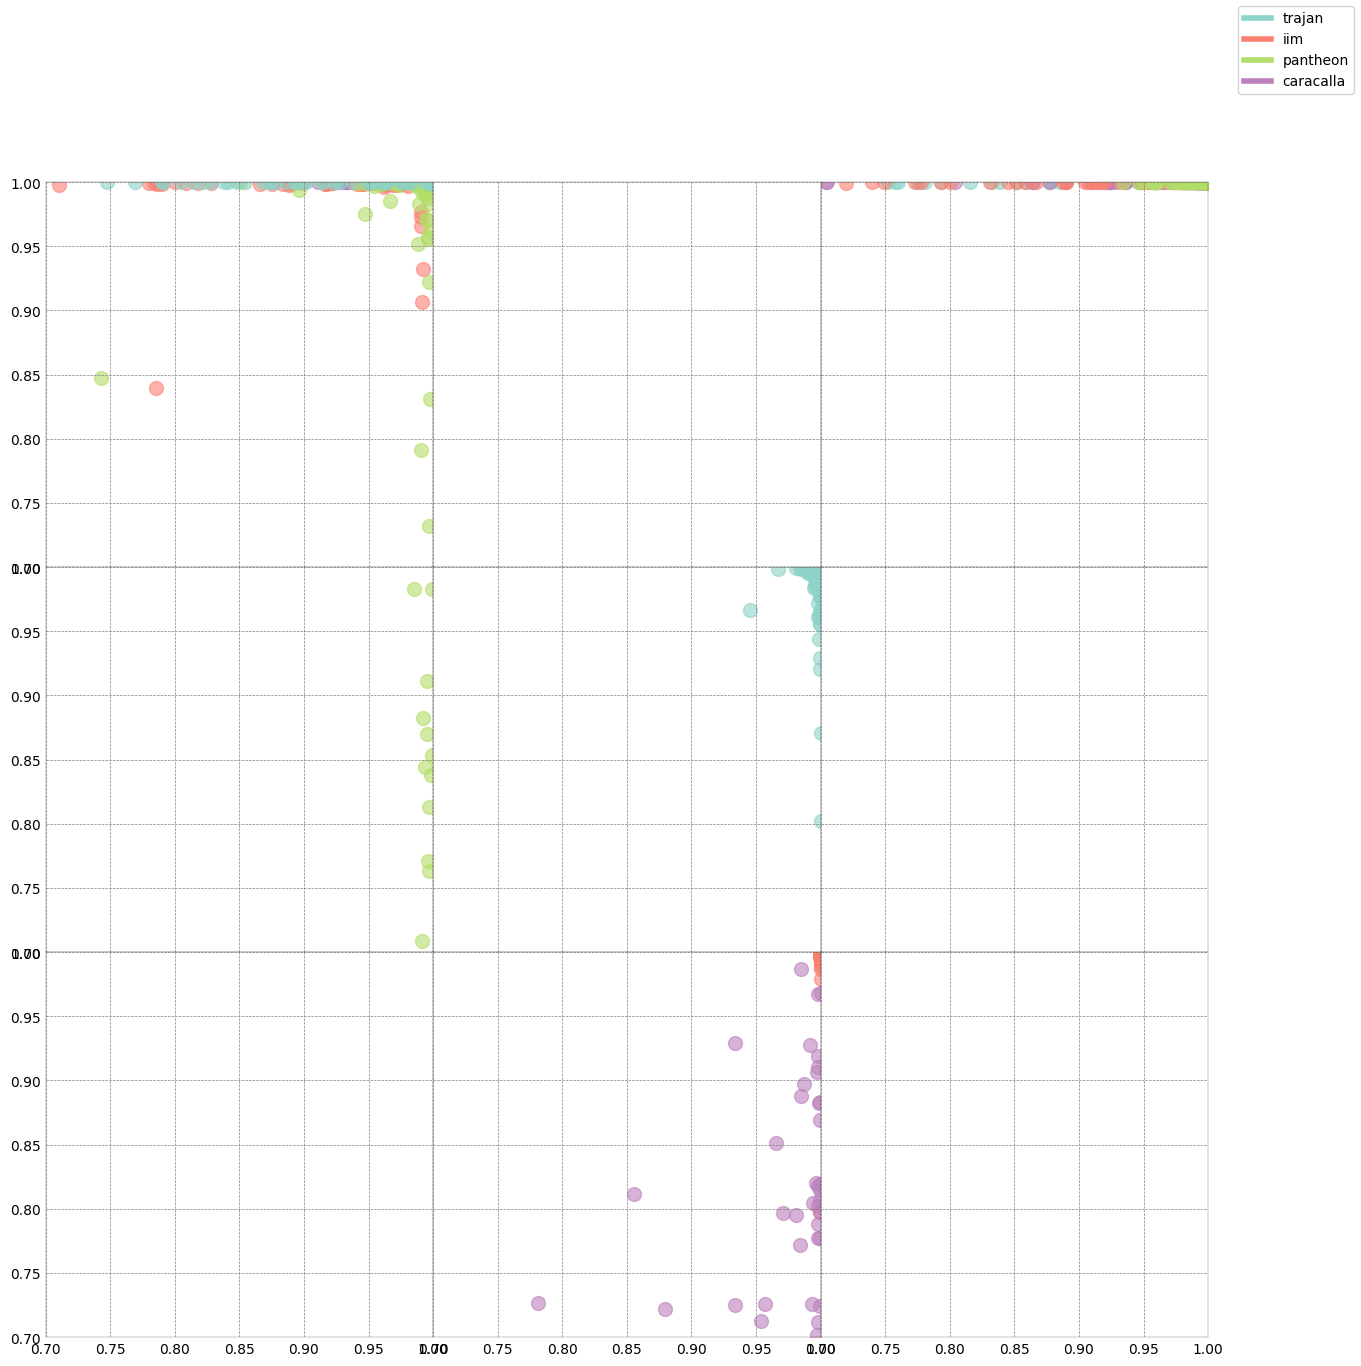

In [ ]:
# Initialize the dictionary
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from matplotlib.colors import Normalize

# Initialize the dictionary
grouped_data = {}
color_map = get_cmap('Set3')  # Choose a color map that suits the number of buildings
norm = Normalize(vmin=0, vmax=len(set(data['bldg'] for data in prediction_dataset)))

# Grouping data based on 'bldg'+'route' and also creating a color mapping for each unique building
bldg_colors = {bldg: color_map(norm(i)) for i, bldg in enumerate(set(data['bldg'] for data in prediction_dataset))}

for data in prediction_dataset:
    key = data['bldg'] + '+' + data['route']
    start_max_idx = np.argmax(aggregated_data[key]['start'])
    end_max_idx = np.argmax(aggregated_data[key]['end'])

    if key not in grouped_data:
        grouped_data[key] = {'label': [start_max_idx, end_max_idx], 'xy_values': []}

    # Appending the xy values
    grouped_data[key]['xy_values'].append((data['start_prediction'][start_max_idx], data['end_prediction'][end_max_idx]))

# Plotting
fig, axes = plt.subplots(3, 3, figsize=(15, 15), gridspec_kw={'wspace': 0, 'hspace': 0})

# Plotting
for i in range(3):
    for j in range(3):
        ax = axes[i, j]
        inv_i = 2 - i
        ax.set_xlim(0.7, 1)
        ax.set_ylim(0.7, 1)
        ax.grid(True, which='both', color='#808080', linestyle='--', linewidth=0.5)
        ax.tick_params(axis='both', which='both', length=0)

        for key, value in grouped_data.items():
            if value['label'] == [j, inv_i]:
                x_vals, y_vals = zip(*value['xy_values'])
                bldg = key.split('+')[0]  # Extract building name
                ax.scatter(x_vals, y_vals, color=bldg_colors[bldg], label=bldg, s=100, alpha=0.6)

        # Hiding inner axes labels
        if i < 2:
            ax.set_xticklabels([])
        if j > 0:
            ax.set_yticklabels([])

# Creating a custom legend for buildings
custom_lines = [plt.Line2D([0], [0], color=bldg_colors[bldg], lw=4) for bldg in bldg_colors]
fig.legend(custom_lines, [bldg for bldg in bldg_colors], loc='upper right')

# Styling
for axis in axes.flatten():
    for spine in axis.spines.values():
        spine.set_edgecolor((0, 0, 0, 0.8))
        spine.set_linewidth(0.2)

plt.show()

##3D scatter

In [ ]:
import plotly.graph_objects as go
import numpy as np
from matplotlib import colors as mcolors
from matplotlib.cm import get_cmap
from matplotlib.colors import Normalize

# Assuming prediction_dataset and inverse_map are already defined

# Initialize the color map and normalization
examine_type = 'room+exterior'
color_map = get_cmap('Set3')  # Using 'Set3' colormap
norm = Normalize(vmin=0, vmax=len(set(data['bldg'] for data in prediction_dataset)))

# Create a color mapping for each unique building
bldg_colors = {bldg: color_map(norm(i)) for i, bldg in enumerate(set(data['bldg'] for data in prediction_dataset))}

# Filter data for the specific label2 ('passage+room')
filtered_data = [d for d in prediction_dataset if d['label2'] == examine_type]

# Create 3D scatter plot
fig = go.Figure()

for data in filtered_data:
    # Extract start and end point coordinates
    start_point = data['start_prediction'][:3]
    end_point = data['end_prediction'][:3]

    # Get building label and corresponding color
    bldg_label = data['bldg']
    hex_color = mcolors.to_hex(bldg_colors[bldg_label])

    # Add the start and end points as scatter plot
    fig.add_trace(go.Scatter3d(x=[start_point[0]], y=[start_point[1]], z=[start_point[2]],
                           mode='markers',
                           marker=dict(size=15, color=hex_color, opacity=0.6),
                           name='Start Points',
                           text=bldg_label,  # Use 'bldg' labels for hover text
                           hoverinfo='text'))
    fig.add_trace(go.Scatter3d(x=[end_point[0]], y=[end_point[1]], z=[end_point[2]],
                           mode='markers',
                           marker=dict(size=15, color=hex_color, symbol='cross', opacity=0.6),
                           name='End Points',
                           text=bldg_label,  # Use 'bldg' labels for hover text
                           hoverinfo='text'))

    # Add a line between the start and end points
    fig.add_trace(go.Scatter3d(
        x=[start_point[0], end_point[0]],
        y=[start_point[1], end_point[1]],
        z=[start_point[2], end_point[2]],
        mode='lines',
        line=dict(color=hex_color, width=2),
        opacity=0.2,
        hoverinfo='none'
    ))

# Update layout
fig.update_layout(title='3D Scatter Plot with Lines',
                  scene=dict(
                      xaxis=dict(title='Room', range=[0, 1], nticks=10,linecolor ='black',linewidth=5,gridcolor='gray'),
                      yaxis=dict(title='Passage', range=[0, 1], nticks=10,linecolor ='black',linewidth=5,gridcolor='gray'),
                      zaxis=dict(title='Exterior', range=[0, 1], nticks=10,linecolor ='black',linewidth=5,gridcolor='gray'),
                      aspectmode='cube'
                  ),
                  plot_bgcolor='rgba(255, 255, 255, 1)',
                  template='none')
fig.update_layout(margin=dict(r=5, l=5, b=5, t=5), height=1100, width=1200)
fig.update_layout(scene_aspectmode="cube")
fig.update_layout(
    scene_camera=dict(
        eye=dict(x=1.25, y=1.25, z=1.25),  # Update these values to change the camera position
        projection=dict(type='orthographic')
    ),
)

fig.show()

<ipython-input-103-ac7d0a967dca>:11: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



In [ ]:
import plotly.graph_objects as go
import numpy as np
from matplotlib.cm import get_cmap
from matplotlib.colors import Normalize
examination_type = 'passage+room'

# Initialize the color map and normalization
color_map = get_cmap('Set3')  # Using 'Set3' colormap
norm = Normalize(vmin=0, vmax=len(set(data['bldg'] for data in prediction_dataset)))

# Create a color mapping for each unique building
bldg_colors = {bldg: color_map(norm(i)) for i, bldg in enumerate(set(data['bldg'] for data in prediction_dataset))}

# Prepare your prediction_dataset and inverse_map here

# Create label1 and label2 for each data point
for data in prediction_dataset:
    data['label1'] = data['bldg']  # Use 'bldg' only for color assignment
    start_max_idx = np.argmax(data['start_prediction'])
    end_max_idx = np.argmax(data['end_prediction'])
    data['label2'] = inverse_map[start_max_idx] + '+' + inverse_map[end_max_idx]

# Filter data for the specific label2 ('passage+room')
filtered_data = [d for d in prediction_dataset if d['label2'] == examination_type]

# Prepare data for plotting
start_x, start_y, start_z, end_x, end_y, end_z = [], [], [], [], [], []
bldg_labels = []  # Labels for coloring

for data in filtered_data:
    # Start and End point coordinates
    start_x.append(data['start_prediction'][0])
    start_y.append(data['start_prediction'][1])
    start_z.append(data['start_prediction'][2])
    end_x.append(data['end_prediction'][0])
    end_y.append(data['end_prediction'][1])
    end_z.append(data['end_prediction'][2])
    bldg_labels.append(data['bldg'])  # Collect 'bldg' labels for color assignment

# Convert color tuples from RGBA to HEX
hex_colors = [mcolors.to_hex(bldg_colors[bldg]) for bldg in bldg_labels]

# Create 3D scatter plot
fig = go.Figure()

# Adding start points
fig.add_trace(go.Scatter3d(x=start_x, y=start_y, z=start_z,
                           mode='markers',
                           marker=dict(size=15, color=hex_colors, opacity=0.6),
                           name='Start Points',
                           text=bldg_labels,  # Use 'bldg' labels for hover text
                           hoverinfo='text'))

# Adding end points
fig.add_trace(go.Scatter3d(x=end_x, y=end_y, z=end_z,
                           mode='markers',
                           marker=dict(size=15, color=hex_colors, symbol='cross', opacity=0.6),
                           name='End Points',
                           text=bldg_labels,  # Use 'bldg' labels for hover text
                           hoverinfo='text'))


# Update layout
fig.update_layout(title=f'3D Scatter Plot for {examination_type}',
                  scene=dict(

                      xaxis=dict(title='Room', range=[0, 1], nticks=10, linecolor ='black',linewidth=5,gridcolor='gray'),
                      yaxis=dict(title='Passage', range=[0, 1], nticks=10,linecolor ='black',linewidth=5,gridcolor='gray'),
                      zaxis=dict(title='Exterior', range=[0, 1], nticks=10,linecolor ='black',linewidth=5,gridcolor='gray'),
                      aspectmode='cube'
                  ),
                  plot_bgcolor='rgba(255, 255, 255, 1)',
                  template='none')
fig.update_layout(margin=dict(r=5, l=5, b=5, t=5), height=1100, width=1200)
fig.update_layout(scene_aspectmode="cube")

fig.show()


<ipython-input-155-2210e4e17bc0>:8: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



## K-Means in Demo dataset


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
demo_dataset_wf = []
label_map = {"room":0,"passage":1,"exterior":2}
inverse_map =  {0:"room",1:"passage",2:"exterior"}
memdpc.to(device)
for i,data in enumerate(dataset_demo):
  updated_data = {}
  t_img = data['t_imgs'].to(device)
  feature = extract_single_feature(memdpc, t_img)
  updated_data['feature'] = feature.cpu().detach().numpy().reshape(-1)
  updated_data['type'] = data['start_type']+'+'+data['end_type']
  demo_dataset_wf.append(updated_data)

print(len(demo_dataset_wf))

2700


In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
import numpy as np

# Assuming demo_dataset_wf is your dataset
# Extract features and original string labels
features = [d['feature'] for d in demo_dataset_wf]
string_labels = [d['type'] for d in demo_dataset_wf]

# Convert string labels to integers
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(string_labels)

# Perform K-means clustering
kmeans = KMeans(n_clusters=9, random_state=0, n_init='auto')
clusters = kmeans.fit_predict(features)

# Assign the most common label to each cluster
cluster_labels = {}
for cluster in range(9):
    indices = [i for i, x in enumerate(clusters) if x == cluster]
    if indices:
        # Extract their labels
        cluster_labels[cluster] = np.argmax(np.bincount([labels[i] for i in indices]))

# Map clusters to labels
predicted_labels = [cluster_labels.get(cluster, -1) for cluster in clusters]

# Convert predicted integer labels back to string labels
predicted_string_labels = label_encoder.inverse_transform(predicted_labels)

# Calculate accuracy (note: this is a simplistic metric in this context)
accuracy = np.mean([pred == true for pred, true in zip(predicted_string_labels, string_labels)])

print("Accuracy:", accuracy)

Accuracy: 0.96



An accuracy of 96% from K-means clustering is quite impressive and suggests that the learned features are effectively capturing the underlying structure of your data. Additional analysis
1. Silhouette Score Calculation
This score ranges from -1 to 1, where a high value indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters.

In [ ]:
from sklearn.metrics import silhouette_score

# Assuming 'features' and 'clusters' are defined as in your previous K-means clustering
silhouette_avg = silhouette_score(features, clusters)
print("Silhouette Score: ", silhouette_avg)

Silhouette Score:  0.6515064


2. Adjusted Rand Index (ARI)
This index compares the cluster assignments to the ground truth labels.

In [ ]:
from sklearn.metrics import adjusted_rand_score

# Assuming 'labels' are your true labels and 'clusters' are the labels assigned by K-means
ari = adjusted_rand_score(labels, clusters)
print("Adjusted Rand Index: ", ari)

Adjusted Rand Index:  0.9212761922605643


3. Mutual Information
This measures the agreement of the true labels and clustering labels, ignoring permutations.

In [ ]:
from sklearn.metrics import adjusted_mutual_info_score

ami = adjusted_mutual_info_score(labels, clusters)
print("Adjusted Mutual Information: ", ami)

Adjusted Mutual Information:  0.9488548498214796


4. Cluster Purity
This function computes the purity of each cluster.

In [ ]:
def cluster_purity(clusters, labels):
    cluster_label_counts = {}
    for cluster_label, true_label in zip(clusters, labels):
        if cluster_label not in cluster_label_counts:
            cluster_label_counts[cluster_label] = {}
        if true_label not in cluster_label_counts[cluster_label]:
            cluster_label_counts[cluster_label][true_label] = 0
        cluster_label_counts[cluster_label][true_label] += 1

    purity = 0
    for cluster_label, label_counts in cluster_label_counts.items():
        max_label_count = max(label_counts.values())
        purity += max_label_count

    return purity / len(labels)

print("Cluster Purity: ", cluster_purity(clusters, labels))

Cluster Purity:  0.96


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Perform t-SNE
tsne = TSNE(n_components=2, random_state=0)
X_tsne = tsne.fit_transform(np.array(features))


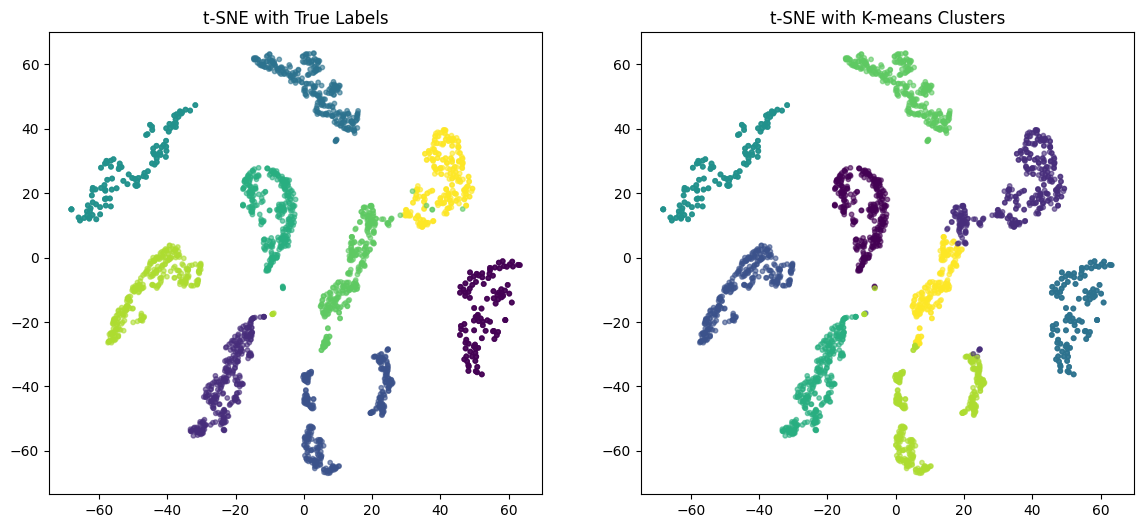

In [ ]:

# Plot with true labels
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels, cmap='viridis', s=10, alpha=0.6)
plt.title('t-SNE with True Labels')
# plt.colorbar()

# Plot with K-means labels
plt.subplot(1, 2, 2)
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=clusters, cmap='viridis', s=10, alpha=0.6)
plt.title('t-SNE with K-means Clusters')
# plt.colorbar()

plt.show()

##Zoom-in Analysis of combined dataset

In [ ]:
prediction_dataset_combined = []
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
label_map = {"room":0,"passage":1,"exterior":2}
inverse_map =  {0:"room",1:"passage",2:"exterior"}
mlp_model.to(device)
memdpc.to(device)
for i,data in enumerate(dataset_combined):
  updated_data = {}
  t_img = data['t_imgs'].to(device)
  feature = extract_single_feature(memdpc, t_img)
  updated_data['feature'] = feature
  updated_data['bldg'] = data['bldg']
  updated_data['route'] = data['route']
  if data['bldg'] == 'demo':
    updated_data['type']=data['start_type']+'+'+data['end_type']
  else:
    outputs = mlp_model(feature.unsqueeze(0)).squeeze(0)
    start_probs, end_probs = outputs[:, :3], outputs[:, 3:]
    start_probs = start_probs.detach().cpu().numpy()[0]
    end_probs = end_probs.detach().cpu().numpy()[0]
    start_max_idx = np.argmax(start_probs)
    end_max_idx = np.argmax(end_probs)
    start_type = inverse_map[start_max_idx]
    end_type = inverse_map[end_max_idx]
    updated_data['type'] = start_type+'+'+end_type
  prediction_dataset_combined.append(updated_data)

print(len(prediction_dataset_combined))


3900


In [ ]:
from scipy.spatial.distance import cosine
from scipy.spatial.distance import cdist
def organize_data(data):
    organized_data = {}
    for item in data:
        key = item['type']
        if key not in organized_data:
            organized_data[key] = {}
        building = item["bldg"]
        feature = np.array(item["feature"].cpu().detach()).reshape(1, -1)
        if building not in organized_data[key]:
            organized_data[key][building] = []
        organized_data[key][building].append(feature)
    return organized_data


def calculate_pairwise_similarity(organized_data):
    comparison_results = {}
    for space_type, buildings in organized_data.items():
        iim_features = buildings["iim"]
        comparison_results[space_type] = {}
        for building, features in buildings.items():
            if building != "iim":
                distances = []
                for iim_feature in iim_features:
                    for feature in features:
                        iim_feature = iim_feature.flatten()
                        feature = feature.flatten()
                        distance = cosine(iim_feature, feature)
                        distances.append(distance)
                average_distance = sum(distances) / len(distances)
                comparison_results[space_type][building] = average_distance
    return comparison_results


def calculate_nearest_neighbors(organized_data):
    nn_results = {}
    for space_type, buildings in organized_data.items():
        if "iim" not in buildings:
            continue
        iim_features = np.array(buildings["iim"])
        nn_results[space_type] = {}
        for building, features in buildings.items():
            if building != "iim":
                building_features = np.array(features)
                # Calculate distances to nearest neighbor
                iim_features = iim_features.reshape(-1, 256)
                building_features = building_features.reshape(-1, 256)
                distances = cdist(iim_features, building_features, metric="cosine")
                min_distances = np.min(distances, axis=1)
                average_distance = np.mean(min_distances)
                nn_results[space_type][building] = average_distance
    return nn_results

organized_data = organize_data(prediction_dataset_combined)
similarity_results = calculate_nearest_neighbors(organized_data)

print(similarity_results)

{'exterior+exterior': {'trajan': 0.017316457009054247, 'caracalla': 0.028518378073705532, 'demo': 0.4125551716884802, 'pantheon': 0.05769237155651274}, 'room+exterior': {'demo': 0.649597154587479, 'trajan': 0.10961446433085839, 'caracalla': 0.04286630671069281, 'pantheon': 0.06697931889269544}, 'passage+passage': {'demo': 0.461377564429791, 'trajan': 0.04613047449631413}, 'room+passage': {'demo': 0.748070285499052, 'pantheon': 0.025388589576111852}, 'passage+room': {'demo': 0.87074887775127, 'caracalla': 0.0710594521764016}}


In [ ]:
print(organized_data.keys())

dict_keys(['exterior+exterior', 'exterior+passage', 'room+exterior', 'passage+exterior', 'passage+passage', 'room+room', 'room+passage', 'passage+room', 'exterior+room'])


In [ ]:
import matplotlib.pyplot as plt

# Creating three separate plots for each space type
plot_num = len(similarity_results)
fig, axes = plt.subplots(1, plot_num, figsize=(plot_num*5, 5))


for i, (space_type, similarities) in enumerate(similarity_results.items()):
    buildings = list(similarities.keys())
    distance = list(similarities.values())
    values = [1/(x+1e-5) for x in distance]
    max_value = max(values)

    axes[i].bar(buildings, values, color="skyblue")
    axes[i].set_title(space_type)
    axes[i].set_xlabel("Building")
    axes[i].set_ylabel("Cosine Similarity")
    axes[i].set_ylim(0, 80)  # Adjusting y-axis limits for better visualization

# Adjusting layout for better visualization
plt.tight_layout()
plt.show()


In [ ]:
from scipy.spatial.distance import cdist


def calculate_nearest_neighbors(organized_data):
    nn_results = {}
    for space_type, buildings in organized_data.items():
        if "iim" not in buildings:
            continue
        iim_features = np.array(buildings["iim"])
        nn_results[space_type] = {}
        for building, features in buildings.items():
            if building != "iim":
                building_features = np.array(features)
                # Calculate distances to nearest neighbor
                iim_features = iim_features.reshape(-1, 256)
                building_features = building_features.reshape(-1, 256)
                distances = cdist(iim_features, building_features, metric="cosine")
                min_distances = np.min(distances, axis=1)
                average_distance = np.mean(min_distances)
                nn_results[space_type][building] = average_distance
    return nn_results

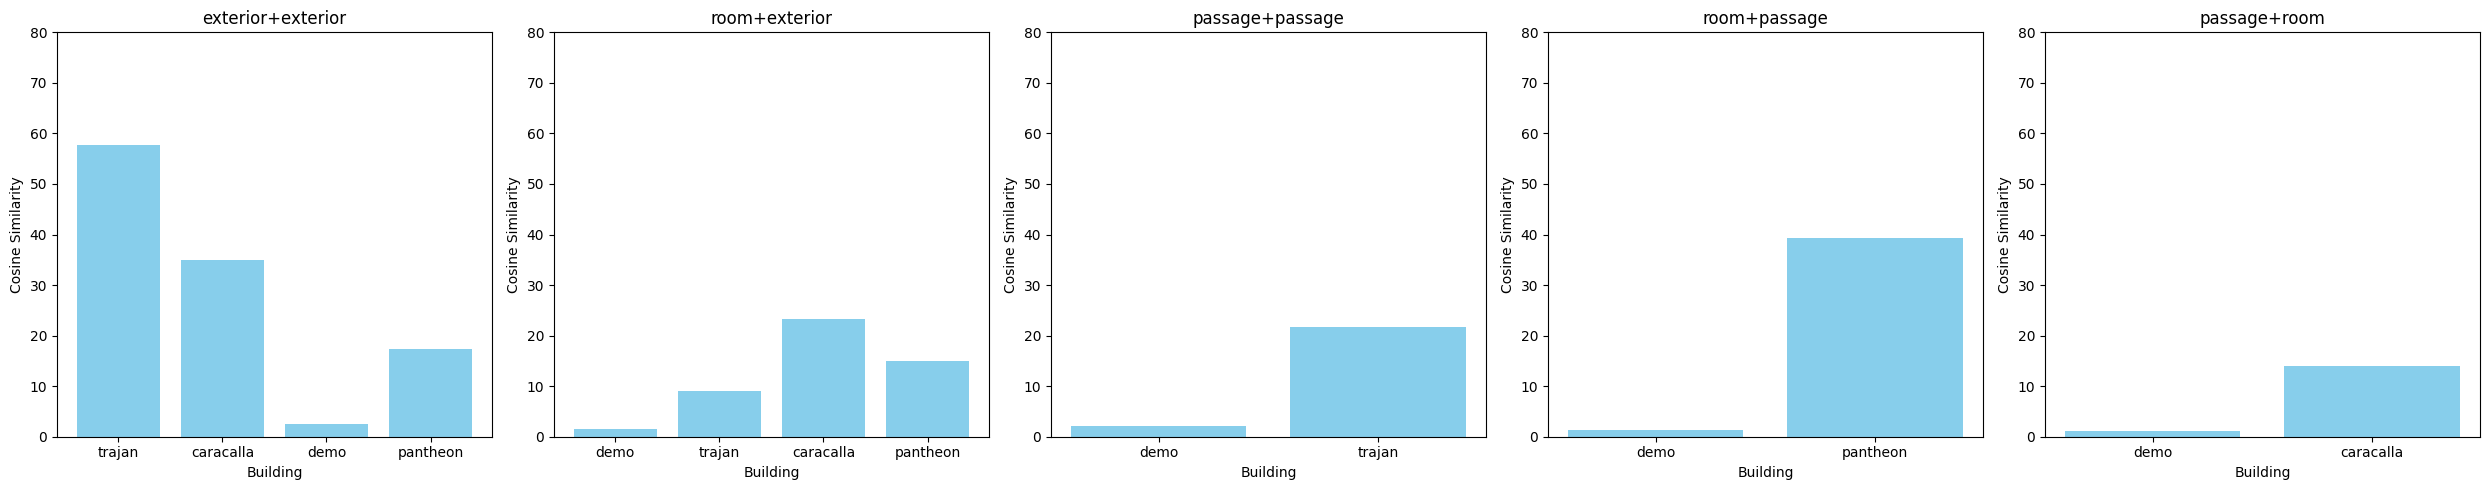

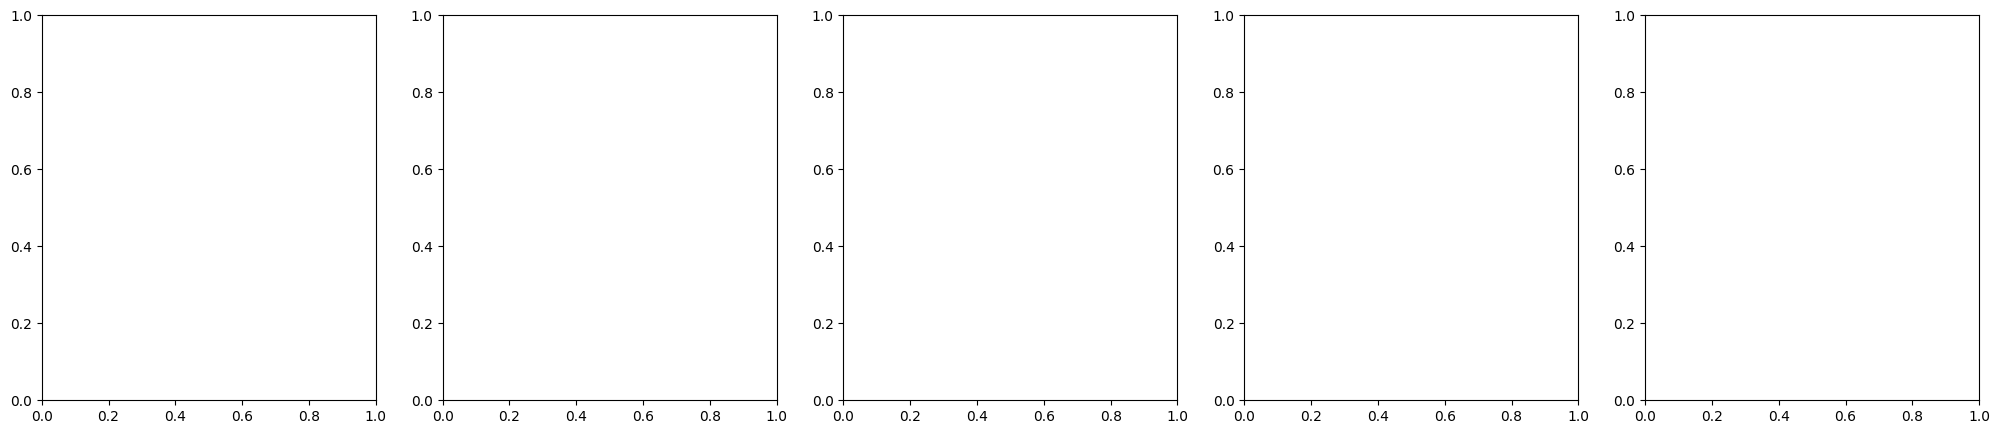

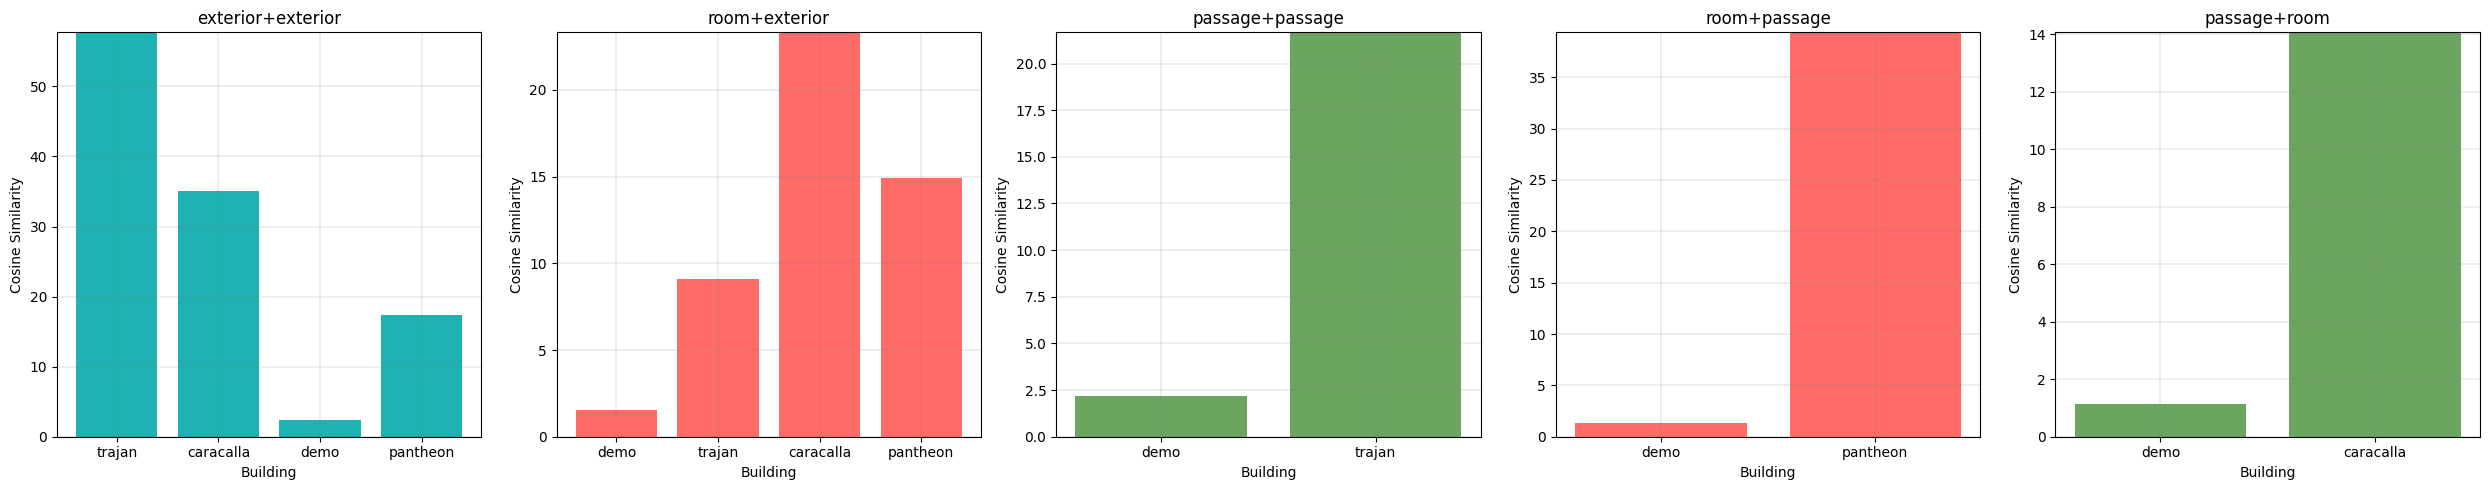

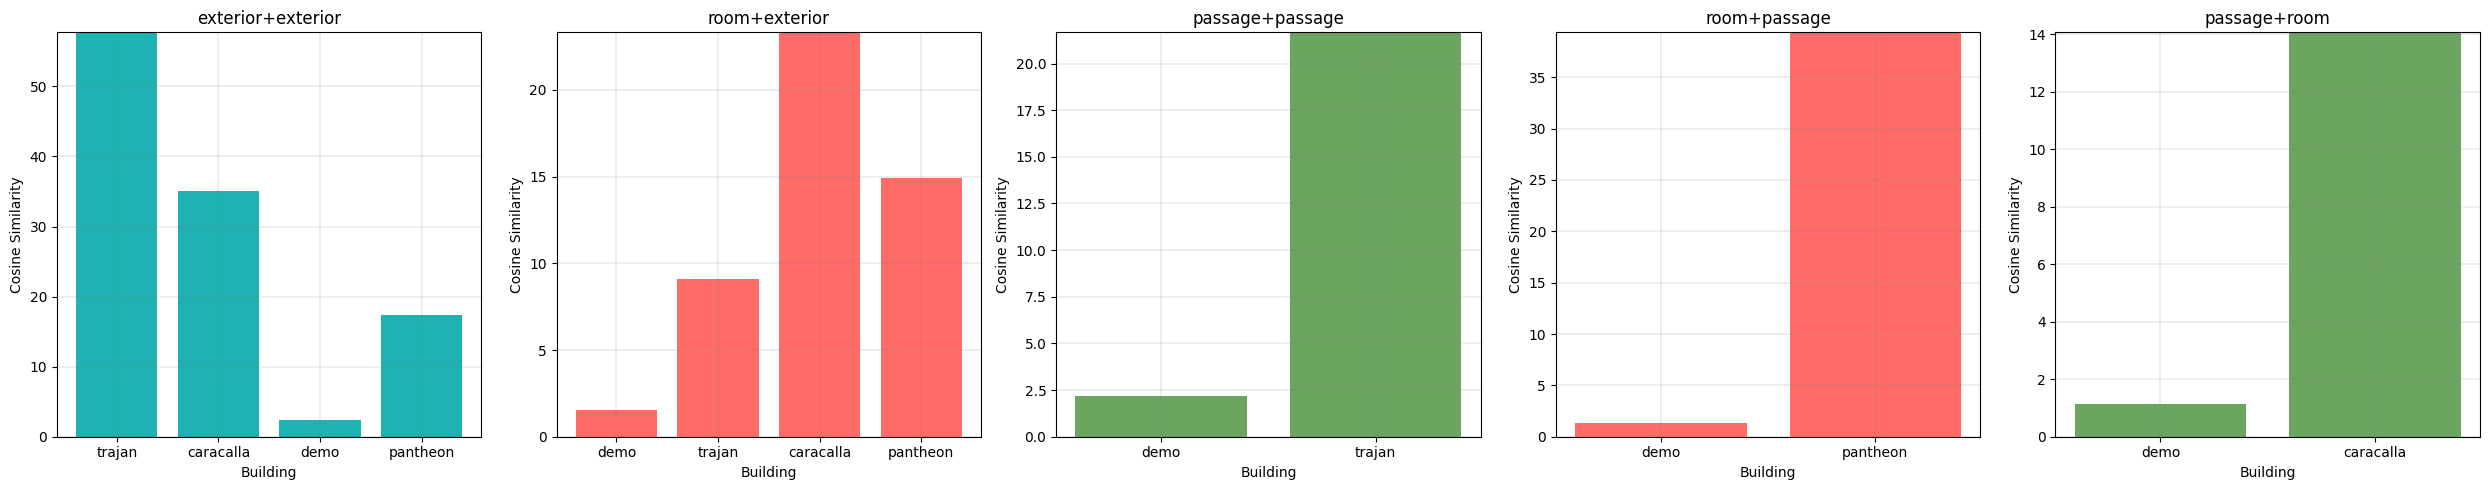

In [ ]:
%matplotlib inline
colors = {
    "exterior+exterior": "#1fb2b2",
    "room+exterior": "#ff6c68",
    "passage+passage": "#6ca55f",
    "room+passage": "#ff6c68",
    "passage+room": "#6ca55f",
    "room+room": "#ff6c68",
    "exterior+room": "#1fb2b2",
    "exterior+passage": "#1fb2b2",
    "room+exterior": "#ff6c68",
    "passage+exterior": "#1fb2b2",
}



fig, axes = plt.subplots(1, plot_num, figsize=(plot_num*5, 5))
nn_results = calculate_nearest_neighbors(organized_data)
for i, (space_type, similarities) in enumerate(nn_results.items()):
    buildings = list(similarities.keys())
    values = list(similarities.values())
    values = [1/(x+1e-5) for x in values]
    max_value = max(values)

    # Set the major and minor ticks
    # Enable the grid on major ticks
    axes[i].grid(which="major", linestyle="-", linewidth="0.2", color="gray")
    axes[i].grid(which="minor", linestyle="--", linewidth="0.2", color="gray")
    # Plot bars
    axes[i].bar(buildings, values, color=colors[space_type])

    # Set title and labels
    axes[i].set_title(space_type)
    axes[i].set_xlabel("Building")
    axes[i].set_ylabel("Cosine Similarity")

    # Set y-axis limits
    axes[i].set_ylim(0, max_value)

    # Set the location of the major ticks at the center of each bar
    axes[i].set_xticks(range(len(buildings)), minor=False)
    axes[i].set_xticklabels(buildings, minor=False)

    # Optionally, set minor ticks if you want to customize their appearance
    # axes[i].set_xticks([x + 0.5 for x in range(len(buildings))], minor=True)

# Adjust layout for better visualization
plt.tight_layout()
plt.show()

In [ ]:
import seaborn as sns


def calculate_similarity_matrix(data):
    similarity_matrix = {}
    for space_type, buildings in data.items():
        building_names = list(buildings.keys())
        matrix = np.zeros((len(building_names), len(building_names)))

        for i, building_i in enumerate(building_names):
            for j, building_j in enumerate(building_names):
                if i != j:
                    distances = cdist(
                        np.array(buildings[building_i]).reshape(-1, 256),
                        np.array(buildings[building_j]).reshape(-1, 256),
                        metric="cosine",
                    )
                    matrix[i, j] = np.mean(np.min(distances, axis=1))
                else:
                    matrix[i, j] = 0

        similarity_matrix[space_type] = (matrix,building_names)

    return similarity_matrix


# Replace organized_data with your actual organized data
similarity_matrices = calculate_similarity_matrix(organized_data)

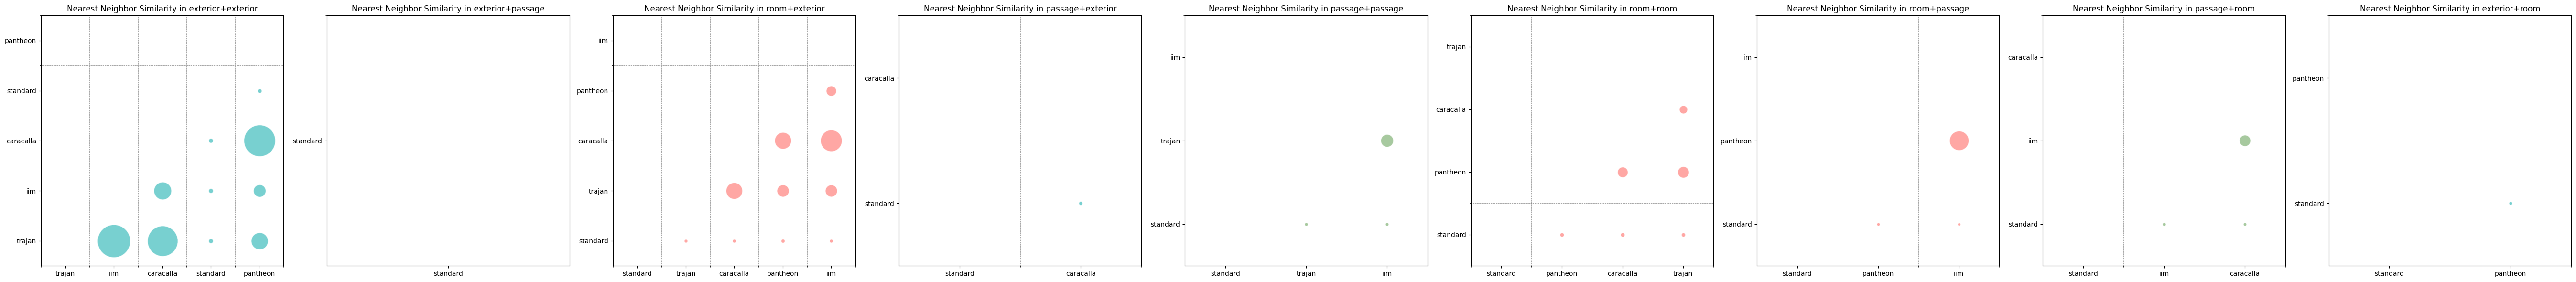

In [ ]:
# Plotting the improved heatmaps with circles
plot_num = len(similarity_matrices)
fig, axes = plt.subplots(1, plot_num, figsize=(plot_num*6, 6))

for i, (space_type, similarity_tuple) in enumerate(similarity_matrices.items()):
    ax = axes[i]
    ax.set_title(f"Nearest Neighbor Similarity in {space_type}")
    matrix,building_names = similarity_tuple
    building_names = ['standard' if x == 'demo' else x for x in building_names]

    # Draw the heatmap
    ax.set_xticks(np.arange(len(building_names)))
    ax.set_yticks(np.arange(len(building_names)))
    ax.set_xticklabels(building_names)
    ax.set_yticklabels(building_names)
    ax.set_xlim(-0.5, len(building_names) - 0.5)
    ax.set_ylim(-0.5, len(building_names) - 0.5)

    # Draw the grid
    ax.grid(which="minor", color="gray", linestyle="--", linewidth=0.5)
    ax.set_xticks(np.arange(-0.5, len(building_names), 1), minor=True)
    ax.set_yticks(np.arange(-0.5, len(building_names), 1), minor=True)

    # Draw circles for the upper triangle
    for j in range(matrix.shape[0]):
        for k in range(j + 1, matrix.shape[1]):
            val = matrix[j, k]
            circle_size = 1/(val+1e-5) * 20  # Adjust circle size scaling factor as needed
            ax.scatter(
                k, j, s=circle_size, color=colors[space_type], alpha=0.6, edgecolors="w"
            )

plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plot
from sklearn.manifold import TSNE
from sklearn.decomposition  import PCA

feature_vectors = []
labels = []
for building_name, features in organized_data['exterior+exterior'].items():
    for vec in features:
        feature_vectors.append(vec.flatten())
        labels.append(building_name)

feature_vectors = np.array(feature_vectors)
random.seed(44)
tsne = TSNE(n_components=2, random_state=254,perplexity=8
            ,n_iter=1000)
pca = PCA(n_components=2)

# reduced_features = pca.fit_transform(feature_vectors)
reduced_features = tsne.fit_transform(feature_vectors)



In [ ]:
from matplotlib import colors as mcolors
from matplotlib.cm import get_cmap
from matplotlib.colors import Normalize
import plotly.graph_objects as go

# Assuming 'prediction_dataset', 'reduced_features', and 'labels' are defined as before

# Convert Matplotlib color to Plotly-compatible color
def mpl_to_plotly_color(color):
    return f'rgba({int(color[0]*255)}, {int(color[1]*255)}, {int(color[2]*255)}, {color[3]})'

# Initialize color mapping
color_map = get_cmap('Set3')
norm = Normalize(vmin=0, vmax=len(set(data['bldg'] for data in dataset_combined)))

# Creating a color mapping for each unique building
bldg_colors = {bldg: mpl_to_plotly_color(color_map(norm(i))) for i, bldg in enumerate(set(data['bldg'] for data in dataset_combined))}
bldg_colors['demo'] = 'rgba(0, 0, 0, 0.3)'
print(bldg_colors)
# Organize data into groups for plotting
grouped_data = {label: {'x': [], 'y': []} for label in set(labels)}
for label, coord in zip(labels, reduced_features):
    grouped_data[label]['x'].append(coord[0])
    grouped_data[label]['y'].append(coord[1])

# Create Plotly plot
fig = go.Figure()

for label, coords in grouped_data.items():
    fig.add_trace(go.Scatter(
        x=coords['x'], y=coords['y'], mode='markers',
        marker=dict(color=bldg_colors[label],size=8,opacity=0.8),
        name=label,opacity=0.6
    ))

fig.update_layout(
    width=800,
    height=800,
    title="t-SNE Visualization of Building Spatial Sequences",
    plot_bgcolor="white",
    xaxis=dict(
        showgrid=True,
        zeroline=True,
        zerolinecolor='lightgray',
        zerolinewidth=0.5,# Enable the grid
        gridcolor='lightgray', # Set grid color to light gray
        gridwidth=0.2,           # Set grid line width
        linewidth=1,           # Set axis line width
        linecolor='gray',      # Set axis line color to gray
        mirror=True           # Mirror the axis lines on all sides
    ),
    yaxis=dict(
        showgrid=True,        # Enable the grid
        gridcolor='lightgray',
        zeroline=True,
        zerolinecolor='lightgray',
        zerolinewidth=0.5,# Set grid color to light gray
        gridwidth=0.2,           # Set grid line width
        linewidth=1,           # Set axis line width
        linecolor='gray',      # Set axis line color to gray
        mirror=True            # Mirror the axis lines on all sides
    )
)

fig.show()

<ipython-input-43-f77d4e257130>:13: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



{'caracalla': 'rgba(141, 211, 199, 1.0)', 'demo': 'rgba(0, 0, 0, 0.3)', 'iim': 'rgba(128, 177, 211, 1.0)', 'pantheon': 'rgba(252, 205, 229, 1.0)', 'trajan': 'rgba(188, 128, 189, 1.0)'}


In [ ]:
from sklearn.cluster import KMeans
from matplotlib import colors as mcolors
from matplotlib.cm import get_cmap
from matplotlib.colors import Normalize
import plotly.graph_objects as go
import numpy as np

# Assuming 'reduced_features' is a NumPy array of the reduced features from your t-SNE.

# Perform K-means clustering
kmeans = KMeans(n_clusters=3, random_state=42,max_iter=200)
kmeans.fit(feature_vectors)
cluster_labels = kmeans.labels_

# Initialize color mapping for the clusters
color_map = get_cmap('Set3')  # Use a different colormap if you prefer
cluster_colors = [mpl_to_plotly_color(color_map(norm(label))) for label in np.unique(cluster_labels)]

# Create Plotly plot
fig = go.Figure()

# Add points to the plot
for cluster_label in np.unique(cluster_labels):
    indices = [i for i, label in enumerate(cluster_labels) if label == cluster_label]
    fig.add_trace(go.Scatter(
        x=reduced_features[indices, 0], y=reduced_features[indices, 1],
        mode='markers',
        marker=dict(color=cluster_colors[cluster_label], size=8, opacity=0.8),
        name=f'Cluster {cluster_label}'
    ))

# Same layout configuration as before
fig.update_layout(
    width=800,
    height=800,
    title="t-SNE Visualization of Building Spatial Sequences",
    plot_bgcolor="white",
    xaxis=dict(
        showgrid=True,
        zeroline=True,
        zerolinecolor='lightgray',
        zerolinewidth=0.5,# Enable the grid
        gridcolor='lightgray', # Set grid color to light gray
        gridwidth=0.2,           # Set grid line width
        linewidth=1,           # Set axis line width
        linecolor='gray',      # Set axis line color to gray
        mirror=True           # Mirror the axis lines on all sides
    ),
    yaxis=dict(
        showgrid=True,        # Enable the grid
        gridcolor='lightgray',
        zeroline=True,
        zerolinecolor='lightgray',
        zerolinewidth=0.5,# Set grid color to light gray
        gridwidth=0.2,           # Set grid line width
        linewidth=1,           # Set axis line width
        linecolor='gray',      # Set axis line color to gray
        mirror=True            # Mirror the axis lines on all sides
    )
)

# Display the figure
fig.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

<ipython-input-51-777adab3b218>:16: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



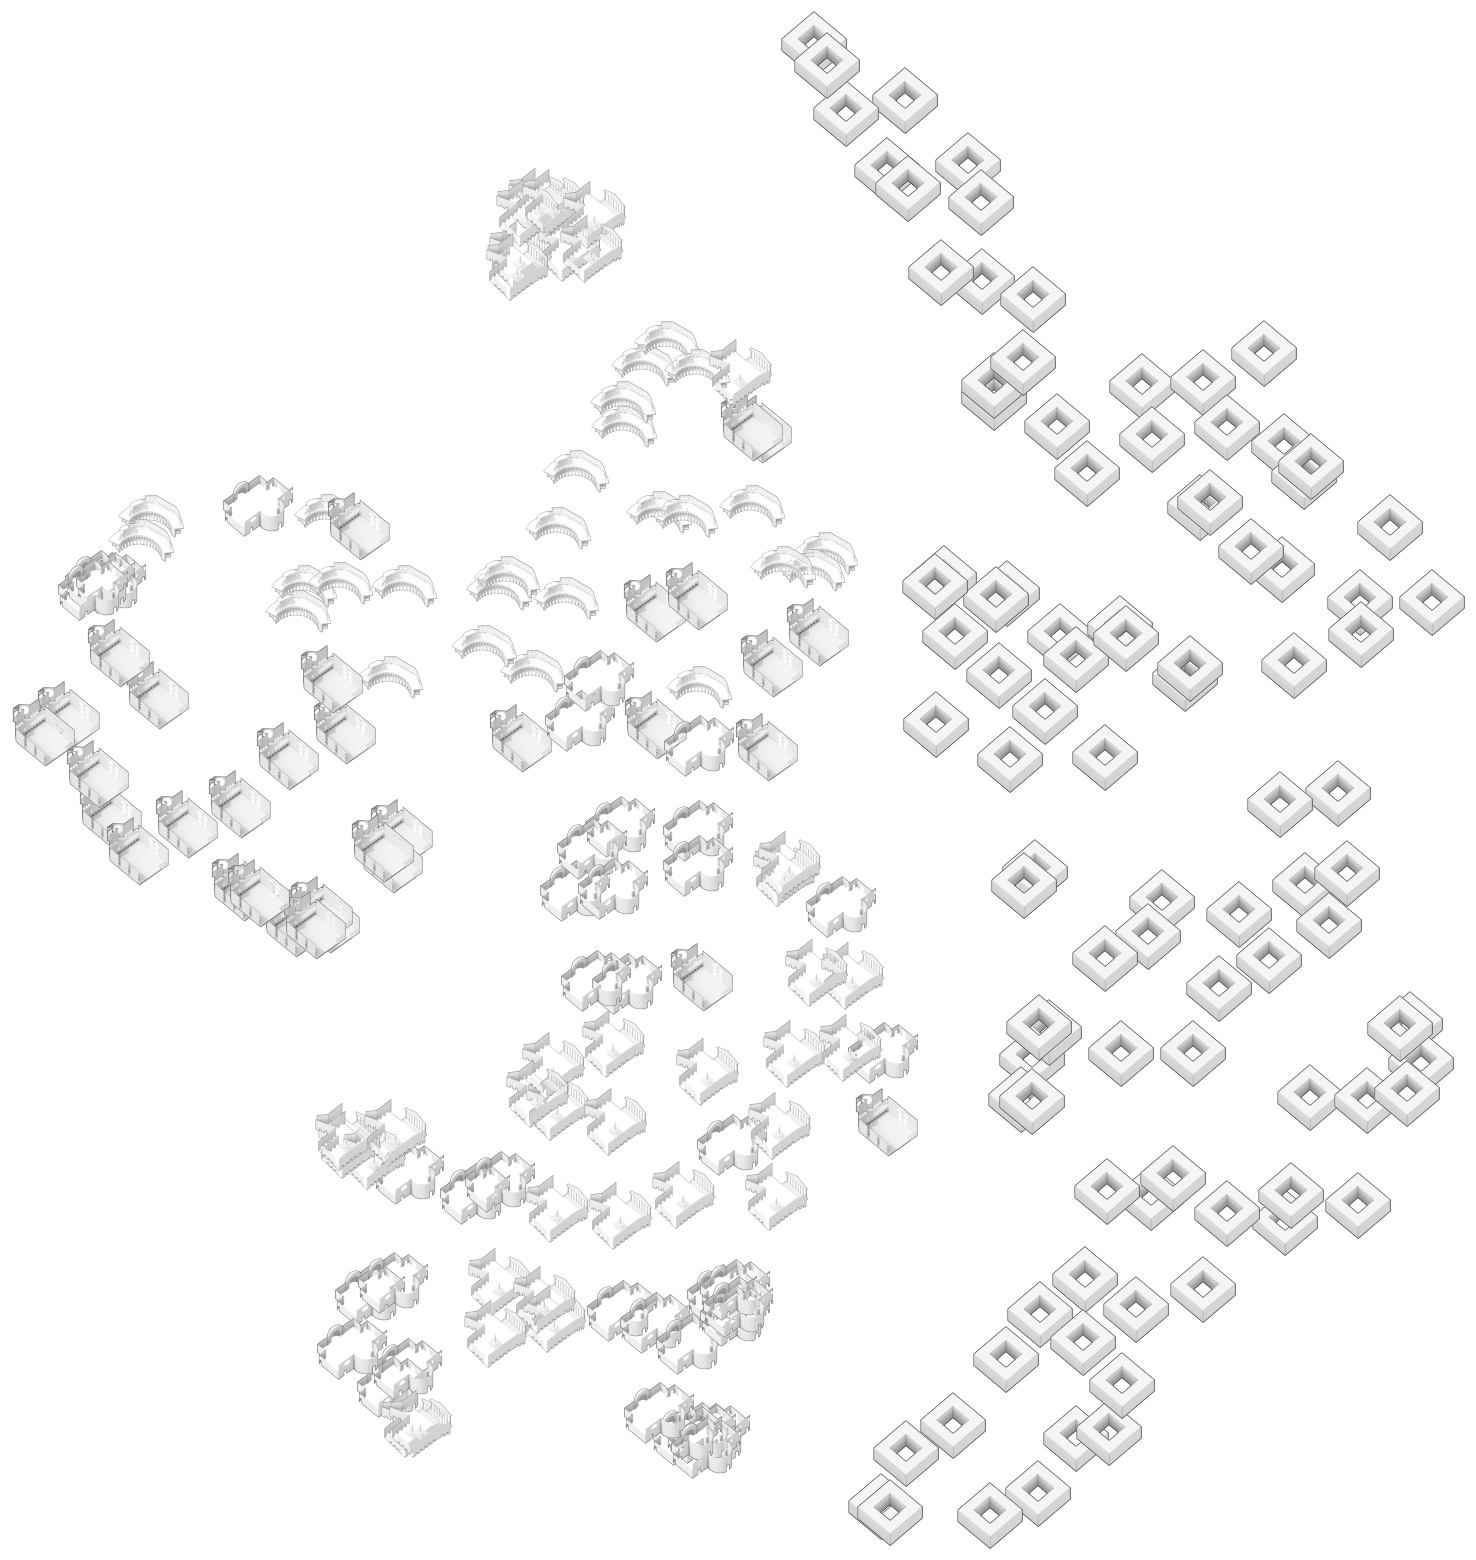

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
def colorize_image(img, color):
    """
    Colorize a grayscale image.

    Args:
    - img: A PIL.Image object of the grayscale image.
    - color: A tuple of (R, G, B), the color to apply to the image.

    Returns:
    - A new PIL.Image object with the color applied.
    """
    # Ensure the image is in RGBA mode
    grayscale = img.convert("L")
    img_rgba = grayscale.convert("RGBA")

    # Create a color layer with the same size as the image and the RGBA color
    color_layer = Image.new("RGBA", img.size, color=color)

    # Composite the color layer onto the grayscale image
    # The alpha channel of the grayscale image is used as a mask to blend the color
    colored_img = Image.composite(color_layer, img_rgba, img_rgba)  # Use alpha channel as mask

    return colored_img
def convertRGBA_to_array(im):
    im.convert("RGBA")
    w, h = im.size
    return np.reshape(np.asarray(im.getdata()), (w, h, 4))

def make_transparent_background(img, color=[255, 255, 255]):
    img = img.convert("RGBA")
    datas = img.getdata()
    newData = []

    for item in datas:
        # Change all white (and very close to white) pixels to transparent
        if item[0] >= 253 and item[1] >= 253 and item[2] >= 253:
            newData.append((255, 255, 255, 0))
        else:
            newData.append(item)

    img.putdata(newData)
    return img
# Assuming 'embedded' is your NumPy array with the t-SNE results
# Step 1: Determine the grid size
grid_size_x = 20  # Number of grid points along the x-axis
grid_size_y = 20 # Number of grid points along the y-axis

# Step 2: Create the grid
x_min, x_max = np.min(reduced_features[:, 0]), np.max(reduced_features[:, 0])
y_min, y_max = np.min(reduced_features[:, 1]), np.max(reduced_features[:, 1])

x_grid = np.linspace(x_min, x_max, grid_size_x)
y_grid = np.linspace(y_min, y_max, grid_size_y)

grid_points = np.array([(x, y) for x in x_grid for y in y_grid])

# Step 3: Find closest points
uniform_idxs = []
for point in grid_points:
    distances = np.sqrt(np.sum((reduced_features - point)**2, axis=1))
    closest_idx = np.argmin(distances)
    uniform_idxs.append(closest_idx)

uniform_idxs = np.unique(uniform_idxs)  # Remove duplicates if any
sampled_features = reduced_features[uniform_idxs]
sampled_labels = np.array(labels)[uniform_idxs]




# Calculate the min and max values for each dimension
x_min, x_max = min(sampled_features[:, 0]), max(sampled_features[:, 0])
y_min, y_max = min(sampled_features[:, 1]), max(sampled_features[:, 1])

# Calculate size for images
size = 0.025 * min(x_max-x_min, y_max-y_min)

plt.figure(figsize=(20, 20))
for i,feature in enumerate(sampled_features):
    x,y = feature
    label = sampled_labels[i]
    extent = (x - size, x + size, y - size, y + size)
    img_path = f'./{label}_bw.png'

    try:
        img = Image.open(img_path)  # Read the image file
        img = make_transparent_background(img, color=[0, 0, 0])
        # color_label = cluster_labels[i]
        # rgba_color = cluster_colors[color_label].replace('rgba', '').replace('(', '').replace(')', '').split(',')
        # color_tuple =(int(rgba_color[0]), int(rgba_color[1]), int(rgba_color[2]),1)
        # img_colored = colorize_image(img, color_tuple)
        plt.imshow(img, extent=extent)
    except FileNotFoundError:
        print(f"File not found: {img_path}")
        continue
plt.xlim((x_min - size, x_max + size))
plt.ylim((y_min - size, y_max + size))
plt.axis("off")
plt.show()

In [ ]:
cluster_colors[1]

'rgba(190, 186, 218, 1.0)'